In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jj

### The Spiking Neural Network
Now it is time to put everything together. The network structure is the same of that in the simple neural network in hopes of creating a logical XOR gate. Due to time constraints, the implementation of the network is done by a strict set of arrays with slicing, so it can be a bit hard to follow, but follow this slicing: 
The neuron layers are sliced on axis in this order: neuron number, pulse vs control channel, phase vs voltage. The flux is neuron number, only one channel, and time. The internal currents are neuron number, and pulse vs control. The output current is output neuron number, input neuron number, and the four associated parameters v dv i and di. Weights are output neurons, and input neurons.

In [2]:
## Time domain set up
time = 10000 # Final Time
n = time/0.05 # Resolution

#time = 300 # Final Time
#n = 20000 # Resolution

dt = time / n # A single time step length
tspan = np.arange(0, time, dt)  # time span
ispan = np.zeros((2,np.size(tspan)))  # input current span

## System Parameters
lmda = 0.1
gamma = 2.0
lmda_s = 0.5
lmda_p = 0.5
eta = 1
i_in = 0.3
i_b = 2.0

## Weight Parameters
w = 1
dw = 0
threshold = 0.3

A = 0.1 # Additive learning rate
B = 0.1 # Reductive learning rate
tau = 20 # Timescale of learning

## Synapse parameters
Q = 0.05
lmda_syn = 0.3
r12 = 1.4
omega = 1.0


## First Neuron Input Layer
neuron1 = np.zeros((2,2,2,np.size(tspan))) # 2 neurons, pulse and control channel, phase and current, as long as t
ii1 = np.zeros((2,2)) # 2 neurons, 2 input currents

flux1 = np.zeros((2,np.size(tspan))) # 2 neurons, 1 flux, as long as t

io1 = np.zeros((2,4,4)) # 2 neuron output currents connect to 4 neurons with four param i, di, v, and dv


## First set of weights
to1 = np.zeros((2,)) # original time of spike for 2 neurons
#w1 = np.ones((2,4)) # 2 neurons, connected to four separate neurons
w1 = np.random.rand(2,4)
tf1 = np.zeros((4,)) # final time of spike for the 4 neurons
last_fire1 = np.zeros((2,4))


## Second Neuron Hidden Layer
neuron2 = np.zeros((4,2,2,np.size(tspan))) # 4 neurons, 2 channels, as long as t
ii2 = np.zeros((4,2)) # 4 neurons, 4 input currents

flux2 = np.zeros((4,np.size(tspan))) # 4 neurons, 1 flux, as long as t

io2 = np.zeros((4,1,4)) # 4 neuron output currents connect to 1 with four param i, di, v, and dv


## Second set of weights
to2 = np.zeros((4,))
#w2 = np.ones((4,1)) # 4 neurons, connected to a single neuron
w2 = np.random.rand(4,1)
tf2 = np.zeros((1,))
last_fire2 = np.zeros((1,4))

## Third Neuron Output Layer

neuron3 = np.zeros((1,2,2,np.size(tspan))) # 1 neurons, 2 channels, as long as t
ii3 = np.zeros((1,2)) # 1 neurons, 2 input currents

flux3 = np.zeros((1,np.size(tspan))) # 1 neurons, 1 flux, as long as t


## Define training current
ispan[0,0:int(np.size(ispan[0,:])/3)] = i_in
ispan[1,int(np.size(ispan[0,:])/3):2*int(np.size(ispan[0,:])/3)] = i_in

## Define testing current
times = np.array([[350,367,384],[401,418,435],[452,469,486]])
p = int(np.size(ispan[0,:])/500)
ps = p*times
pf = p*(times+1)
for i in [0,1,2]:
    ispan[0,ps[0,i]:pf[0,i]] = i_in # Check for 1,0
    ispan[1,ps[1,i]:pf[1,i]] = i_in # Check for 0,1
    ispan[:,ps[2,i]:pf[2,i]] = i_in # Check for 1,1

In [3]:
## Initial Conditions, Nueron 1

# Most IC's are 0, so I will not include the code for sake of time,
#but it can be added by slicing each variable and setting any time domain to 0 and others to IV's

ii1[:,0] = -lmda*(neuron1[:,1,0,0] + neuron1[:,0,0,0]) + lmda_s*ispan[:,0] + (1-lmda_p)*i_b
ii1[:,1] = (-lmda*(neuron1[:,1,0,0] + neuron1[:,0,0,0]) + lmda_s*ispan[:,0] - lmda_p*i_b)/eta

## Initial Conditions, Synapse

# Same as above

## Initial Conditions, Neuron 2

# Same as above

ii2[:,0] = -lmda*(neuron2[:,1,0,0] + neuron2[:,0,0,0]) + lmda_s*0 + (1-lmda_p)*i_b
ii2[:,1] = (-lmda*(neuron2[:,1,0,0] + neuron2[:,0,0,0]) + lmda_s*0 - lmda_p*i_b)/eta

## Initial Conditions, Neuron 3

ii3[:,0] = -lmda*(neuron3[:,1,0,0] + neuron3[:,0,0,0]) + lmda_s*0 + (1-lmda_p)*i_b
ii3[:,1] = (-lmda*(neuron3[:,1,0,0] + neuron3[:,0,0,0]) + lmda_s*0 - lmda_p*i_b)/eta

### Running the Simulation
The over all architechure goes by calculating the timestep of the first layer, checking first weights forward, output to second layer, calculating second layer, checking first weights backwards, checking second weights forward, output to third layer, calculating third layer, and checking second weights backwards.  

The training phase is the first two thirds of the time domain involving exposing the network to the first channel input being on and the second off. The second third is the reverse. The outputs and inputs of our network are now binary instead of continuous because it only has the states of firing and not firing, so this is why I chose a logic gate. Then after the training phase, I start the testing phase. This is done by only inputing for a short period of time a stimuli, and seeing what happens. I pulse them with large enough time difference that any further weight adjustments are minimal, and test the first input again 3 times, then the second 3 times, and then both at once.

In [4]:
oc = [0]  # Output Current to plot later
wspan = [1]
## Operate the Circuit
for j in range(np.size(tspan)-1):
    ## First Neuron
    for i in [0,1]:
        neuron1[i,0,:,j+1] = jj.junction_step(neuron1[i,0,0,j],neuron1[i,0,1,j],dt,gamma,ii1[i,0])
        neuron1[i,1,:,j+1] = jj.junction_step(neuron1[i,1,0,j],neuron1[i,1,1,j],dt,gamma,ii1[i,1])
        ii1[i,:] = jj.currents(lmda,neuron1[i,0,0,j+1],neuron1[i,1,0,j+1],lmda_s,ispan[i,j+1],lmda_p,i_b,eta)
        flux1[i,j+1] = lmda*(neuron1[i,0,0,j+1] + neuron1[i,1,0,j+1])

    
        ## Check weights
        if (flux1[i,j-1] < flux1[i,j] > flux1[i,j+1] and flux1[i,j] > threshold):
            to1[i] = tspan[j]
            for ii in [0,3]:    
                if last_fire1[i,ii] == 1:
                    w1[i,ii] = w1[i,ii] + jj.change_weights(A,B,tau,tf1[ii],to1[i])
                    last_fire1[i,ii] = 0
    
    ## Output to Second Neuron
        for ii in [0,1,2,3]:
            io1[i,ii,:] = jj.synapse_step(io1[i,ii,0], io1[i,ii,1], io1[i,ii,2], io1[i,ii,3],
                                          neuron1[i,0,1,j], neuron2[ii,0,1,j], neuron2[ii,1,1,j], 
                                          gamma, omega, Q, lmda, lmda_syn, r12, dt)
   
    #oc.append(w*i_o)
    
    ## Second Neuron
    for i in [0,1,2,3]:
        current1 = np.sum(w1[:,i]*io1[:,i,2])
        neuron2[i,0,:,j+1] = jj.junction_step(neuron2[i,0,0,j],neuron2[i,0,1,j],dt,gamma,ii2[i,0])
        neuron2[i,1,:,j+1] = jj.junction_step(neuron2[i,1,0,j],neuron2[i,1,1,j],dt,gamma,ii2[i,1])
        ii2[i,:] = jj.currents(lmda,neuron2[i,0,0,j+1],neuron2[i,1,0,j+1],lmda_s,current1,lmda_p,i_b,eta)
        flux2[i,j+1] = lmda*(neuron2[i,0,0,j+1] + neuron2[i,1,0,j+1])
        
        ## Check weights 1
        if (flux2[i,j-1] < flux2[i,j] > flux2[i,j+1] and flux2[i,j] > threshold):
            tf1[i] = tspan[j]
            for ii in [0,1]:    
                if last_fire1[ii,i] == 0:
                    w1[ii,i] = w1[ii,i] + jj.change_weights(A,B,tau,tf1[i],to1[ii])
                    last_fire1[ii,i] = 1
                    
        ## Check weights 2
        if (flux2[i,j-1] < flux2[i,j] > flux2[i,j+1] and flux2[i,j] > threshold):
            to2[i] = tspan[j]  
            if last_fire2[0,i] == 1:
                w2[i,0] = w2[i] + jj.change_weights(A,B,tau,tf2[0],to2[i])
                last_fire2[0,i] = 0
                    
    ## Output to Third neuron
        io2[i,0,:] = jj.synapse_step(io2[i,0,0], io2[i,0,2], io2[i,0,2], io2[i,0,3],
                                      neuron2[i,0,1,j], neuron3[0,0,1,j], neuron3[0,1,1,j], 
                                      gamma, omega, Q, lmda, lmda_syn, r12, dt)
    ## Third Neuron
    current2 = np.sum(w2*io2[:,0,2])
    neuron3[0,0,:,j+1] = jj.junction_step(neuron3[0,0,0,j],neuron3[0,0,1,j],dt,gamma,ii3[0,0])
    neuron3[0,1,:,j+1] = jj.junction_step(neuron3[0,1,0,j],neuron3[0,1,1,j],dt,gamma,ii3[0,1])
    ii3[0,:] = jj.currents(lmda,neuron3[0,0,0,j+1],neuron3[0,1,0,j+1],lmda_s,current1,lmda_p,i_b,eta)
    flux3[0,j+1] = lmda*(neuron3[0,0,0,j+1] + neuron3[0,1,0,j+1])
    
    ## Check weights 2
    if (flux3[0,j-1] < flux3[0,j] > flux3[0,j+1] and flux3[0,j] > threshold):
        tf2[0] = tspan[j]
        for ii in [0,1,2,3]:    
            if last_fire2[0,ii] == 0:
                w2[ii,0] = w2[ii,0] + jj.change_weights(A,B,tau,tf2[0],to2[ii])
                last_fire2[0,ii] = 1

/home/pi/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply
/home/pi/Documents/Git/Josephson_Junction_Neuromorphic-Raspi4-/Neural Networking/jj.py:71: RuntimeWarning: overflow encountered in double_scalars
  - lmda_syn/lmda * id_0 - v_0 - Q/omega * vd_0)*dt
/home/pi/Documents/Git/Josephson_Junction_Neuromorphic-Raspi4-/Neural Networking/jj.py:69: RuntimeWarning: overflow encountered in double_scalars
  v = v_0 + vd_0 * dt
/home/pi/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/pi/Documents/Git/Josephson_Junction_Neuromorphic-Raspi4-/Neural Networking/jj.py:71: RuntimeWarning: invalid value encountered in double_scalars

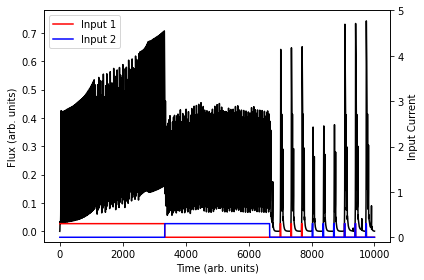

In [11]:
## Plotting
fig, ax1 = plt.subplots()

fig.patch.set_facecolor('white')

ax1.set_xlabel('Time (arb. units)')
ax1.set_ylabel('Flux (arb. units)')
ax1.plot(tspan,flux3[0], 'k')

# ax1.set_xlim(0,250)
# ax1.set_ylim(-0.1,0.6)
# ax1.title('Output')

ax2 = ax1.twinx()
ax2.plot(tspan,ispan[0,:], 'r')
ax2.plot(tspan,ispan[1,:], 'b-')
ax2.set_ylim(-0.1,5)
ax2.set_ylabel('Input Current')
ax2.legend(["Input 1","Input 2"],loc='upper left')

fig.tight_layout()
plt.show()

### Results and Discussion
Here is the final result of the network, and it is evident that it did not work entirely as desired. We can see that the training phase probably had the effect of reversal by training it with two inputs. This training method was based off of [this paper](http://ceur-ws.org/Vol-1525/paper-21.pdf), where they expose the network to a pattern and then test it against a different pattern. There are a few flaws applying this method to my network because of a number of different things.  

I did not apply any bias to my system. This is already present in the form of $i_b$, and in the paper I use my model in, they show that a negative bias current will cause the coupling to become inhibitory, so that if a neuron is firing it will prevent the next neuron from firing. This means that in my training, it became impossible for the neurons to inhibit others. I attempted to mitigate this by allowing the weights to begin as negative so that weights could theoretically sum to zero, but this proved unstable where occasionally the output flux would diverge and occasionally becoming negative implying a backwards current flow which is not what is intended for the system. So this implementation is definitely in need of reworking. The final weights I went with remained positive which means that I would never be able to inhibit firing, so my gate is essentially an OR gate and no longer exclusive.

The training phase having two long periods of different inputs may not be the proper way to train a model by exposure. There could be overtraining in the first part of training meaning that the new inputs for the next set of training might be irrelevant. I also guessed with taking the parameters of the learning function as I was looking at a different paper for the training method as the model being presented. So perhaps a lot of these problems can be fixed by having better parameters for the system.

The actual results to seem to suggest a learning of sorts is actually occuring. The initial training has a strong response when tested, but when the second channel is tested, while it still reacts, it has a much smaller amplitude. This means that the network remembers the first training set more than the second set. This is also why the combined is larger than them both because there is no inhibiting, it is just seeing that it is supposed to fire from the first and second output, so it fires even more. So while this model did not function as intended, the underlying behaviour still shows the network learning.

Time domain was limited because of the training model having no cap that I was not able to implement, but noticed was mentioned in the paper. So it is possible that the learning rates need to also be a function of the current weight to prevent an infinite current.

Overall, coding this from scratch with only the model of the neuron was difficult as many resources do not explain their methods directly have have most of the network buried in functions and not presented. I was able to get the model working in some capacity, but not in the intended way. However, this definitely shows that it is possible to use these neuron models for training. Most of the model failure is from implementation and the training implementation.

The best way to bring the project forward would be to fix the implementation of the neuron layers and initial conditions to tidy the code and make is understandable. Having a deeper understanding of the model would invariably help the development of the training method, or even using a different one. New methods do have the ability to back propogate in a supervised manor allowing direct learning approach instead of taking this guessing game. Implementing bias will allow the network to inhibit firing without the possibility of reversing current flow. This model does indeed show promise, it just needs more work.